In [59]:
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [60]:
import pandas as pd
from math import floor

from darts.timeseries import TimeSeries
from darts.dataprocessing.transformers import MissingValuesFiller, Scaler
from darts.models import TCNModel

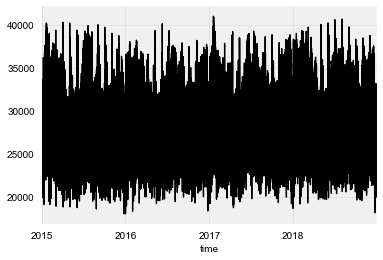

In [61]:
energy_df = pd.read_csv('energy_dataset.csv', usecols=['time', 'total load actual'])
energy_df['time'] = pd.to_datetime(energy_df['time'], utc=True)
energy_df['time']= energy_df.time.dt.tz_localize(None)

energy_series = TimeSeries.from_dataframe(energy_df, 'time', ['total load actual'])
energy_series.plot()
plt.show()

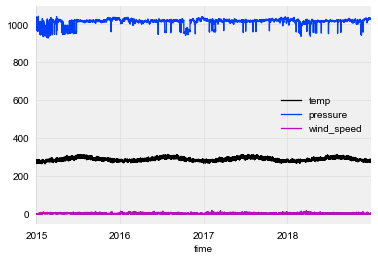

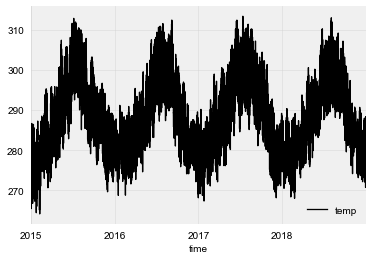

In [62]:
weather_df = pd.read_csv('weather_features.csv', usecols=['dt_iso', 'city_name', 'temp', 'pressure', 'wind_speed'])
weather_df = weather_df[weather_df['city_name'] == 'Madrid']
weather_df.drop(columns='city_name', inplace=True)
weather_df.rename(columns = {'dt_iso':'time'}, inplace = True)
weather_df['time'] = pd.to_datetime(weather_df['time'], utc=True)
weather_df['time'] = weather_df.time.dt.tz_localize(None)
weather_df.drop_duplicates(subset='time', keep='first', inplace=True)

weather_series = TimeSeries.from_dataframe(weather_df, 'time', ['temp', 'pressure', 'wind_speed'])
weather_series.plot()
plt.legend()
plt.show()

weather_series['temp'].plot()
plt.legend()
plt.show()

In [47]:
series = energy_series.stack(weather_series)[-floor((24*365*1.25)):]
series = series.add_datetime_attribute('weekday')

In [42]:
series = MissingValuesFiller().transform(series)

scaler = Scaler()
series = scaler.fit_transform(series)

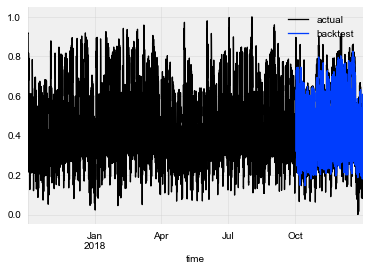

In [23]:
model = TCNModel(input_length=24*7,
                 input_size=5,
                 output_length=6,
                 output_size=1)

backtest = model.backtest(training_series=series,
                          target_series=series['0'],
                          start=0.8,
                          forecast_horizon=6,
                          stride=1,
                          retrain=False,
                          use_full_output_length=True,
                          verbose=True)


series['0'].plot(label="actual")
backtest.plot(label="backtest")
plt.legend()
plt.show()

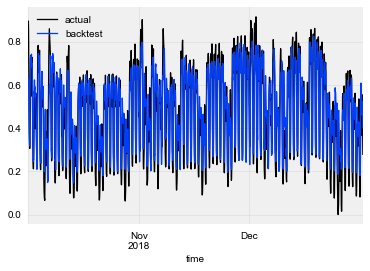

In [24]:
from darts.utils import get_timestamp_at_point
series['0'][get_timestamp_at_point(0.8, series):].plot(label="actual")
backtest.plot(label="backtest")
plt.legend()
plt.show()

In [25]:
from darts.metrics import smape

print(smape(series['0'], backtest))

18.142570782567667
